In [12]:
import pandas as pd
import numpy as np

# 1) Read the file
df = pd.read_csv("/content/Heart_Disease dataset.csv")

print("✅ Data loaded successfully")
print("Shape before processing:", df.shape)

# 2) Number of missing values before processing
missing_before = df.isna().sum().sum()
#print("Number of missing values before processing:", missing_before)

# 3) Fill numerical columns with Median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 4) Fill categorical columns with Mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# 5) Number of missing values after processing
missing_after = df.isna().sum().sum()
print("Number of missing values after processing:", missing_after)

print("✅ Missing values have been fully handled")
print("Shape after processing:", df.shape)


✅ Data loaded successfully
Shape before processing: (66310, 18)
Number of missing values after processing: 0
✅ Missing values have been fully handled
Shape after processing: (66310, 18)


In [13]:
# Number of rows before removing duplicates
rows_before = df.shape[0]
print("Number of rows before removing duplicates:", rows_before)

# Remove duplicate rows
df = df.drop_duplicates()

# Number of rows after removing duplicates
rows_after = df.shape[0]
print("Number of rows after removing duplicates:", rows_after)

# Number of removed rows
print("Number of removed rows:", rows_before - rows_after)

# Confirm no duplicates remain
print("Number of duplicate rows after removal:", df.duplicated().sum())


Number of rows before removing duplicates: 66310
Number of rows after removing duplicates: 65237
Number of removed rows: 1073
Number of duplicate rows after removal: 0


In [14]:
import pandas as pd

# 1️⃣ Separate the Target from the Features
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# 2️⃣ Select categorical columns in the Features only
categorical_cols = X.select_dtypes(include=['object']).columns
print("Categorical columns to be encoded:")
print(categorical_cols)

# 3️⃣ One-Hot Encoding for Features only
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 4️⃣ Encode the Target (Yes / No → 1 / 0)
y = y.map({"Yes": 1, "No": 0})

# 5️⃣ Merge X and y again into one DataFrame (if needed)
df_encoded = pd.concat([X, y], axis=1)

print("✅ Encoding completed successfully")
print("Shape after Encoding:", df_encoded.shape)


Categorical columns to be encoded:
Index(['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
       'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')
✅ Encoding completed successfully
Shape after Encoding: (65237, 38)


In [15]:
from sklearn.model_selection import train_test_split

X = X
y = y

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (52189, 37)
Test shape: (13048, 37)


In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Show class distribution before balancing
print("Before SMOTE:")
print(Counter(y))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Show class distribution after balancing
print("\nAfter SMOTE:")
print(Counter(y_resampled))


Before SMOTE:
Counter({0: 59669, 1: 5568})

After SMOTE:
Counter({0: 59669, 1: 59669})


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)


(52189, 37)
(13048, 37)


✅ Confusion Matrix:
[[11667   267]
 [  951   163]]

📊 Confusion Matrix Details:
True Positive (TP):  163
True Negative (TN):  11667
False Positive (FP): 267
False Negative (FN): 951

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11934
           1       0.38      0.15      0.21      1114

    accuracy                           0.91     13048
   macro avg       0.65      0.56      0.58     13048
weighted avg       0.88      0.91      0.89     13048


✅ Accuracy:
0.9066523605150214


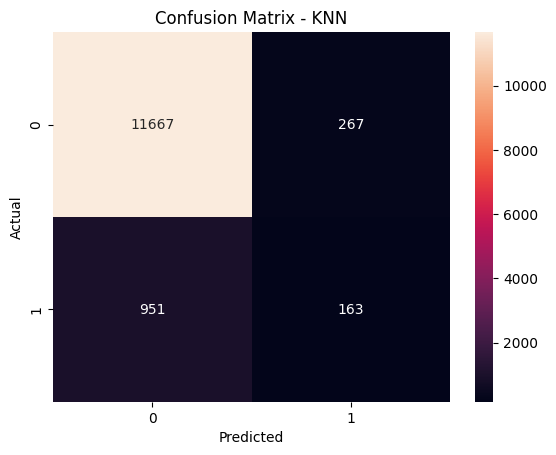

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a common fixed value for k
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn.predict(X_test_scaled)

# Confusion Matrix
print("✅ Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

print("\n📊 Confusion Matrix Details:")
print(f"True Positive (TP):  {TP}")
print(f"True Negative (TN):  {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

# Classification Report
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
print("\n✅ Accuracy:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
import gradio as gr
import pandas as pd

# =========================
# Prediction Function
# =========================
def predict(
    BMI, PhysicalHealth, MentalHealth, SleepTime,
    Smoking, AlcoholDrinking, Stroke, DiffWalking,
    Sex, AgeCategory, Race, Diabetic, PhysicalActivity,
    GenHealth, Asthma, KidneyDisease, SkinCancer
):
    # Create DataFrame from user input
    user_raw = pd.DataFrame([{
        "BMI": BMI,
        "PhysicalHealth": PhysicalHealth,
        "MentalHealth": MentalHealth,
        "SleepTime": SleepTime,
        "Smoking": Smoking,
        "AlcoholDrinking": AlcoholDrinking,
        "Stroke": Stroke,
        "DiffWalking": DiffWalking,
        "Sex": Sex,
        "AgeCategory": AgeCategory,
        "Race": Race,
        "Diabetic": Diabetic,
        "PhysicalActivity": PhysicalActivity,
        "GenHealth": GenHealth,
        "Asthma": Asthma,
        "KidneyDisease": KidneyDisease,
        "SkinCancer": SkinCancer
    }])

    # One-Hot Encoding
    user_encoded = pd.get_dummies(user_raw)

    # Match training columns
    user_encoded = user_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Scaling
    user_scaled = scaler.transform(user_encoded)

    # Prediction
    pred = knn.predict(user_scaled)[0]
    prob = knn.predict_proba(user_scaled)[0][1]

    if pred == 1:
        return f"⚠️ Heart Disease Detected\nEstimated Probability: {prob*100:.2f}%"
    else:
        return f"✅ No Heart Disease\nEstimated Probability: {prob*100:.2f}%"


# =========================
# Gradio UI
# =========================
with gr.Blocks(theme=gr.themes.Soft()) as demo:

    gr.Markdown("## 🫀 Heart Disease Prediction System")
    gr.Markdown(
        "Enter patient data below. "
        "Please respect the allowed ranges for numerical values."
    )

    # ---------- Numerical Inputs ----------
    with gr.Row():
        BMI = gr.Number(
            label="BMI",
            value=25,
            minimum=10,
            maximum=60,
            info="Body Mass Index (10 – 60)"
        )
        SleepTime = gr.Number(
            label="Sleep Time (hours)",
            value=7,
            minimum=1,
            maximum=24,
            info="Average sleep hours per day (1 – 24)"
        )

    with gr.Row():
        PhysicalHealth = gr.Number(
            label="Physical Health (0 – 30)",
            value=5,
            minimum=0,
            maximum=30,
            info="Days physical health was not good"
        )
        MentalHealth = gr.Number(
            label="Mental Health (0 – 30)",
            value=3,
            minimum=0,
            maximum=30,
            info="Days mental health was not good"
        )

    gr.Markdown("### Lifestyle & Medical History")

    # ---------- Categorical Inputs ----------
    Smoking = gr.Dropdown(
        ["Yes", "No"],
        label="Smoking",
        value="No",
        info="Does the patient smoke?"
    )

    AlcoholDrinking = gr.Dropdown(
        ["Yes", "No"],
        label="Alcohol Drinking",
        value="No",
        info="Heavy alcohol consumption"
    )

    Stroke = gr.Dropdown(
        ["Yes", "No"],
        label="Stroke",
        value="No",
        info="History of stroke"
    )

    DiffWalking = gr.Dropdown(
        ["Yes", "No"],
        label="Difficulty Walking",
        value="No",
        info="Serious difficulty walking or climbing stairs"
    )

    Sex = gr.Dropdown(
        ["Male", "Female"],
        label="Sex",
        value="Male",
        info="Biological sex"
    )

    AgeCategory = gr.Dropdown(
        [
            "18-24","25-29","30-34","35-39","40-44","45-49","50-54",
            "55-59","60-64","65-69","70-74","75-79","80 or older"
        ],
        label="Age Category",
        info="Age group"
    )

    Race = gr.Dropdown(
        ["White", "Black", "Asian", "Hispanic", "Other"],
        label="Race",
        info="Race category"
    )

    Diabetic = gr.Dropdown(
        ["Yes", "No"],
        label="Diabetic",
        info="Has diabetes"
    )

    PhysicalActivity = gr.Dropdown(
        ["Yes", "No"],
        label="Physical Activity",
        info="Engages in physical activity"
    )

    GenHealth = gr.Dropdown(
        ["Excellent", "Very good", "Good", "Fair", "Poor"],
        label="General Health",
        info="Self-reported general health"
    )

    Asthma = gr.Dropdown(
        ["Yes", "No"],
        label="Asthma",
        info="Has asthma"
    )

    KidneyDisease = gr.Dropdown(
        ["Yes", "No"],
        label="Kidney Disease",
        info="Has kidney disease"
    )

    SkinCancer = gr.Dropdown(
        ["Yes", "No"],
        label="Skin Cancer",
        info="Has skin cancer"
    )

    # ---------- Action ----------
    btn = gr.Button("🔍 Predict")
    output = gr.Textbox(label="Prediction Result")

    btn.click(
        predict,
        inputs=[
            BMI, PhysicalHealth, MentalHealth, SleepTime,
            Smoking, AlcoholDrinking, Stroke, DiffWalking,
            Sex, AgeCategory, Race, Diabetic, PhysicalActivity,
            GenHealth, Asthma, KidneyDisease, SkinCancer
        ],
        outputs=output
    )

demo.launch()


/tmp/ipython-input-812448984.py:56: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://adfc7e0d36c0e33620.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
